# This is an implementation of a neural network using only raw python and numpy
* The network is trained on the cats and dogs dataset
* The network has 4 hidden layers with 20 neurons each

Coding the neural network from scratch is a by no means a good idea for real world applications. However, it is a good way to understand the inner workings of a neural network. This notebook is a good starting point for anyone who wants to learn about neural networks.


In [2]:
import numpy as np

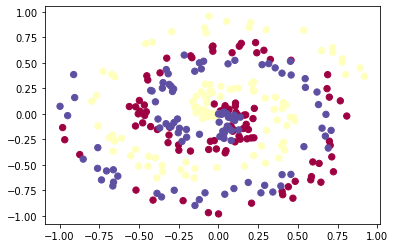

In [12]:
def create_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points) # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

import matplotlib.pyplot as plt
X, y = create_data(100, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

### Layer class

In [30]:
np.random.seed(0)

class Layer_Dense:

    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

The `__init__` method takes in two parameters, `n_inputs` and `n_neurons`. `n_inputs` is the number of input neurons, and `n_neurons` is the number of neurons in this layer.

In this method, the weights and biases of the layer are initialized. The weights are initialized randomly using the `np.random.randn` function. The shape of the weights matrix is `(n_inputs, n_neurons)`. The biases are initialized to zeros with a shape of `(1, n_neurons)`.

The `forward` method is the implementation of the forward pass for this layer. It takes in inputs, which is a matrix of shape `(batch_size, n_inputs)`. The output of this layer is calculated by taking the dot product of inputs and weights, and then adding the biases. The output of this layer has a shape of `(batch_size, n_neurons)`.

The `backward` method in this code is responsible for computing the gradients of the loss with respect to the weights, biases, and inputs of a layer. This is an important step in the process of training a neural network using gradient descent.

The `dvalues` parameter represents the derivative of the loss with respect to the output of the layer, which is passed in from the subsequent layer during backpropagation.

The method first computes the gradients of the loss with respect to the weights and biases using the chain rule of calculus. The `dweights` are computed as the dot product between the transpose of the input values and the `dvalues`. This results in a matrix of the same shape as the `weights` matrix, representing the gradient of the loss with respect to each weight parameter.

Similarly, the `dbiases` are computed by summing the `dvalues` along the rows (axis=0) and keeping the dimensions consistent with the `biases` matrix.

Finally, the gradient of the loss with respect to the inputs is computed as the dot product between the `dvalues` and the transpose of the `weights`. This allows the gradient to be propagated backwards through the network to update the weights of the previous layer.

Overall, the `backward` method is a crucial step in the backpropagation algorithm for training neural networks, and this implementation computes the gradients efficiently using matrix operations.


In summary, this class implements a dense layer in a neural network with `n_inputs` input neurons and `n_neurons` output neurons. The weights and biases are randomly initialized, and the forward pass is calculated by taking the dot product of the inputs and weights, and adding biases. The backward pass computes the gradients of the loss with respect to the weights, biases, and inputs of the layer.

In [29]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [27]:

class Activation_Softmax:

    def forward(self, inputs):

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    def backward(self, dvalues):
            
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [24]:
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values


    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        return data_loss
    

class Loss_CategoricalCrossentropy(Loss):
        # Categorical Cross-Entropy loss
        # y_pred is a matrix with probabilities
        # y_true is a vector with labels

        def forward(self, y_pred, y_true):
    
            samples = len(y_pred)
    
            # Clip data to prevent division by 0
            y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
    
            # Probabilities for target values - only if categorical labels
            if len(y_true.shape) == 1:
                correct_confidences = y_pred_clipped[range(samples), y_true]
    
            # Mask values - only for one-hot encoded labels
            elif len(y_true.shape) == 2:
                correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
    
            # Losses
            negative_log_likelihoods = -np.log(correct_confidences)

            return negative_log_likelihoods
        
        def backward(self, dvalues, y_true):
    
            samples = len(dvalues)
            labels = len(dvalues[0])
    
            # If labels are sparse, turn them into one-hot vector
            if len(y_true.shape) == 1:
                y_true = np.eye(labels)[y_true]
    
            # Calculate gradient
            self.dinputs = -y_true / dvalues
            # Normalize gradient
            self.dinputs = self.dinputs / samples

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

In [26]:
class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples
